# Analyze LMAN waveform characteristics

- Get values from unit_profile table

In [1]:
# Import packages
import sys
sys.path.append(r"..")
from pyfinch.database.load import ProjectLoader
from util.plot import plot_bar_comparison, plot_per_day_block
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyfinch.utils import save
from pyfinch.utils.draw import remove_right_top

save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Waveform', add_date=False)

# Load database
db = ProjectLoader().load_db()
# SQL statement
query = """SELECT unit.*, cluster.taskSessionDeafening, cluster.taskSessionPostDeafening, cluster.block10days
    FROM unit_profile unit INNER JOIN cluster ON cluster.id = unit.clusterID
    WHERE cluster.analysisOK
    """

df = db.to_dataframe(query)
# df.dropna(subset=['motifFRUndir'], inplace=True)  # drop out NaNs

## # of neurons

In [2]:
df.groupby('taskName', as_index=False)['unitCategoryUndir'].agg({'nb_units': 'count'}).sort_values('taskName', ascending=False)

,taskName,nb_units
1,Predeafening,21
0,Postdeafening,40


In [3]:
df.columns

Index(['clusterID', 'birdID', 'taskName', 'taskSession', 'site', 'channel',
       'unit', 'region', 'SNR', 'spkHeight', 'spkWidth', 'nbSpk', 'baselineFR',
       'motifFRUndir', 'motifFRDir', 'unitCategoryUndir', 'unitCategoryDir',
       'burstDurationBaseline', 'burstFreqBaseline', 'burstMeanNbSpkBaseline',
       'burstFractionBaseline', 'burstIndexBaseline', 'burstDurationUndir',
       'burstFreqUndir', 'burstMeanNbSpkUndir', 'burstFractionUndir',
       'burstIndexUndir', 'burstDurationDir', 'burstFreqDir',
       'burstMeanNbSpkDir', 'burstFractionDir', 'burstIndexDir',
       'taskSessionDeafening', 'taskSessionPostDeafening', 'block10days'],
      dtype='object')

## Compare SNR

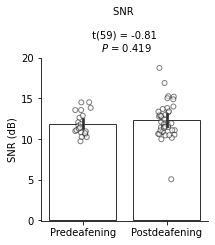

,count,mean,std,min,25%,50%,75%,max
taskName,,,,,,,,
Postdeafening,40.0,12.305350,2.245966,5.065,11.02625,11.8775,13.38625,18.747
Predeafening,21.0,11.863905,1.447969,9.727,10.81700,11.4110,12.87300,14.521


In [11]:
# Parameters
save_fig = False
fig_ext = '.png'

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
plot_bar_comparison(ax, df['SNR'], df['taskName'],
                    # hue_var=df['birdID'],
                    title='SNR', y_label='SNR (dB)',
                    col_order=("Predeafening", "Postdeafening"),
                    y_lim=[-0.05, 20]
                    )

# Save results
if save_fig:
    save.save_fig(fig, save_path, 'SNR', fig_ext=fig_ext)
else:
    plt.show()
    
# Basic stats
df.groupby(['taskName'])['SNR'].describe()

In [12]:
df.groupby(['taskName'])['SNR'].agg('median')

taskName
Postdeafening    11.8775
Predeafening     11.4110
Name: SNR, dtype: float64

## Compare spike width

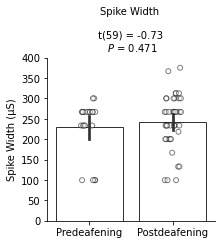

In [5]:
# Parameters
save_fig = False
fig_ext = '.png'

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
plot_bar_comparison(ax, df['spkWidth'], df['taskName'],
                    # hue_var=df['birdID'],
                    title='Spike Width', y_label='Spike Width (µS)',
                    col_order=("Predeafening", "Postdeafening"),
                    y_lim=[0, 400]
                    )
# sns.boxplot(df['taskName'], df['spkWidth'], 
#             ax=ax, width=0.2, color='w', showfliers=True)
# Save results
if save_fig:
    save.save_fig(fig, save_path, 'SpikdWidth', fig_ext=fig_ext)
else:
    plt.show()

## Spike width vs. height (peak-to-trough)

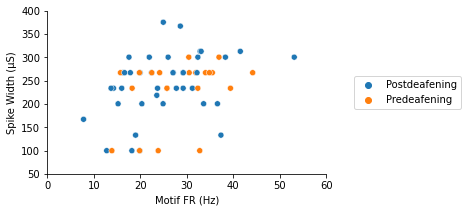

In [6]:
fig, ax = plt.subplots(figsize=(5, 3))
remove_right_top(ax)
sns.scatterplot(x=df['motifFRUndir'], y=df['spkWidth'],
                hue=df['taskName'], ax=ax)

ax.set_xlabel('Motif FR (Hz)')
ax.set_ylabel('Spike Width (µS)')
ax.set_xlim([0, 60])
ax.set_ylim([50, 400])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

## SNR across day blocks

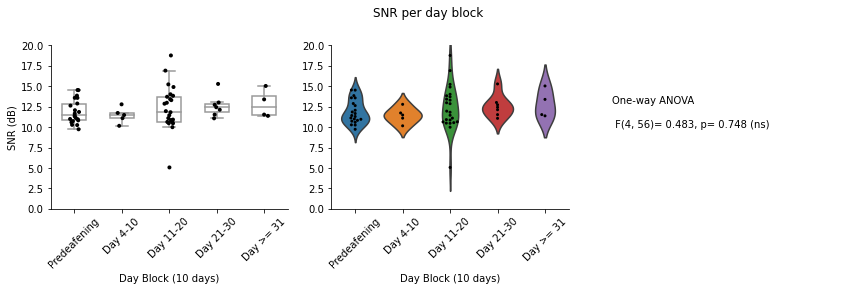

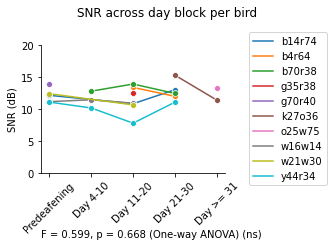

In [7]:
from deafening.plot import plot_per_day_block, plot_line_across_blocks

df_block = df.groupby(['birdID', 'block10days'])['SNR'].mean().reset_index() 
df_block.dropna(inplace=True)

plot_per_day_block(df, ind_var_name='block10days', dep_var_name='SNR',
                   title='SNR per day block',
                   y_label='SNR (dB)', y_lim=[0, 20],
                   plot_type='box',
                   view_folder=True,
                   fig_name='SNR_per_day_block',
                   save_fig=False, fig_ext='.png'
                   )

plot_line_across_blocks(df_block, variable='SNR',
                        y_lim=[0, 20], fig_size=(5, 4),
                        y_label='SNR (dB)',
                        title='SNR across day block per bird',
                        fig_name='SNR_across_day_block_per_bird',
                        view_folder=True,
                        save_fig=False, 
                        fig_ext='.png'
                        )

### Mark std for SNR

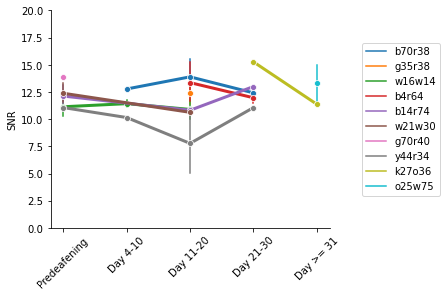

In [9]:
fig, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x='block10days', y='SNR', hue='birdID', data = df, 
             err_style="bars", 
             # ci=95, 
             marker='o', linewidth=3,
             ax=ax)
ax.set_ylim([0, 20])
remove_right_top(ax)
day_block_label_list = ['Predeafening', 'Day 4-10', 'Day 11-20', 'Day 21-30', 'Day >= 31']
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('')
ax.set_xticklabels(day_block_label_list, rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()

In [10]:
df.columns

Index(['clusterID', 'birdID', 'taskName', 'taskSession', 'site', 'channel',
       'unit', 'region', 'SNR', 'spkHeight', 'spkWidth', 'nbSpk', 'baselineFR',
       'motifFRUndir', 'motifFRDir', 'unitCategoryUndir', 'unitCategoryDir',
       'burstDurationBaseline', 'burstFreqBaseline', 'burstMeanNbSpkBaseline',
       'burstFractionBaseline', 'burstIndexBaseline', 'burstDurationUndir',
       'burstFreqUndir', 'burstMeanNbSpkUndir', 'burstFractionUndir',
       'burstIndexUndir', 'burstDurationDir', 'burstFreqDir',
       'burstMeanNbSpkDir', 'burstFractionDir', 'burstIndexDir',
       'taskSessionDeafening', 'taskSessionPostDeafening', 'block10days'],
      dtype='object')

In [20]:
# Apply 10-day block for pre-deafening data
save_fig = True

df['newBlock'] = pd.cut(df['taskSessionDeafening'], [-20, -10, 0, 10, 20, 30, 100], 
       labels=[-2, -1, 0, 1, 2, 3],    
       include_lowest=True
      )
# Plot the results
ind_groups = df['newBlock'].sort_values().unique()

fig, ax = plt.subplots(figsize=(6, 4))
sns.stripplot(data=df, x='newBlock', y='SNR', hue='birdID', ax=ax, jitter=0.1, size=5, edgecolor='k', linewidth=1)
sns.boxplot(data=df, x='newBlock', y='SNR', ax=ax, width=0.5, color='w', showfliers=False)
remove_right_top(ax)
ax.set(xlabel='Days', ylabel='SNR (dB)', ylim=(0, 20))
day_block_label_list = ['-20 ~ 11', '-10 ~ -1', '0 ~ 10', '11 ~20', '21 ~ 30', '>= 31']  # left and right all inclusive
ax.set_xticklabels(day_block_label_list, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
fig.tight_layout()
if save_fig:
    save.save_fig(fig, save_path, 'SNR_blocks', fig_ext='.pdf')

plt.show()